# 手写数字识别

## 1. 数据描述

[MNIST数据集](http://yann.lecun.com/exdb/mnist/)包含以下四个部分:

•训练集图片: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, and 60,000 samples)

•训练集标签: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, and 60,000 labels)

•测试集图片: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, unzipped and 10,000 samples)

•测试集标签: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, and 10,000 labels)

MNIST数据集来自美国国家标准与技术研究所 (NIST)的两个数据集. 测试集包括250个人书写的数字笔迹, 50% 高中生, 和50% 人口统计局的雇员.

## 2. 获取MNIST数据集

In [1]:
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
mnist = read_data_sets("MNIST/", one_hot=True)

D:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST/t10k-images-idx3-ubyte.gz
Extracting MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
import os
import struct
import numpy as np
 
def load_mnist(path, kind='train'):
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images.idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels

In [3]:
X_train, y_train = load_mnist('MNIST/', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

Rows: 60000, columns: 784


In [4]:
X_test, y_test = load_mnist('MNIST/', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


## 3. 查看手写数据

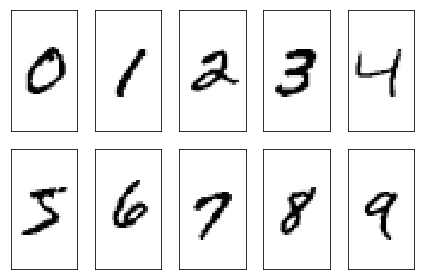

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

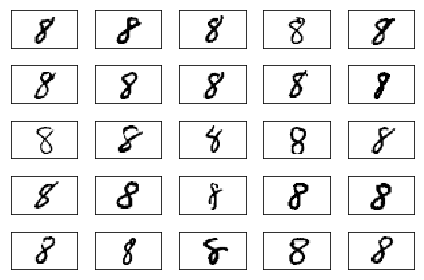

In [7]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 8][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [8]:
import tensorflow as tf
sess = tf.InteractiveSession()

# 4. Softmax 回归

创建占位符

In [9]:
x = tf.placeholder("float", shape=[None, 784])
y_ = tf.placeholder("float", shape=[None, 10])

定义权重和偏移

In [10]:
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

sess.run(tf.global_variables_initializer())

Lost function

In [11]:
y = tf.nn.softmax(tf.matmul(x,W) + b)

In [12]:
cross_entropy = -tf.reduce_sum(y_*tf.log(y))

训练模型

In [13]:
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

In [14]:
for i in range(1000):
  batch = mnist.train.next_batch(50)
  train_step.run(feed_dict={x: batch[0], y_: batch[1]})

模型评估

In [15]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

In [16]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [18]:
print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.8913


# 5. 多层卷积网络

初始化

In [19]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

卷积和数据合并

In [20]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

First layer  

In [21]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

In [22]:
x_image = tf.reshape(x, [-1,28,28,1])

In [23]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

Second layer

In [24]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

Fully connected layer

In [25]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

Apply Dropout to reduce the overfitting

In [26]:
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

Output layer

In [27]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

训练， 评估模型

In [28]:
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())

for i in range(10000):
  batch = mnist.train.next_batch(50)
  if i%500 == 0:
    train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.06
step 500, training accuracy 0.88
step 1000, training accuracy 0.96
step 1500, training accuracy 0.98
step 2000, training accuracy 0.94
step 2500, training accuracy 0.98
step 3000, training accuracy 0.98
step 3500, training accuracy 1
step 4000, training accuracy 1
step 4500, training accuracy 0.94
step 5000, training accuracy 1
step 5500, training accuracy 1
step 6000, training accuracy 0.98
step 6500, training accuracy 1
step 7000, training accuracy 1
step 7500, training accuracy 1
step 8000, training accuracy 0.96
step 8500, training accuracy 1
step 9000, training accuracy 1
step 9500, training accuracy 1
test accuracy 0.9901
